In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib.inline
import warnings
warnings.filterwarnings(action='ignore')
import optuna
from sklearn.ensemble import HistGradientBoostingRegressor
from category_encoders import CatBoostEncoder
from sklearn.model_selection import train_test_split, cross_val_score,KFold



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [2]:
train=pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv')

In [3]:
test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv')

In [4]:
test.head()

,id,date,country,store,product
0,136950,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,136951,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,136952,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,136953,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,136954,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB


In [6]:
train.isnull().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [7]:
train['date']=pd.to_datetime(train['date'])

In [8]:
train.head()

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [9]:
train.isnull().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [10]:
train.describe()

,id,num_sold
count,136950.00000,136950.000000
mean,68474.50000,165.522636
std,39534.20402,183.691575
min,0.00000,2.000000
25%,34237.25000,46.000000
50%,68474.50000,98.000000
75%,102711.75000,184.000000
max,136949.00000,1380.000000


In [11]:
for col in train.columns:
    print(f"{col} has {len(train[col].unique())} values")

id has 136950 values
date has 1826 values
country has 5 values
store has 3 values
product has 5 values
num_sold has 1028 values


In [12]:
products= train['product'].unique()

In [13]:
products

array(['Using LLMs to Improve Your Coding',
       'Using LLMs to Train More LLMs',
       'Using LLMs to Win Friends and Influence People',
       'Using LLMs to Win More Kaggle Competitions',
       'Using LLMs to Write Better'], dtype=object)

In [14]:
len(products)

5

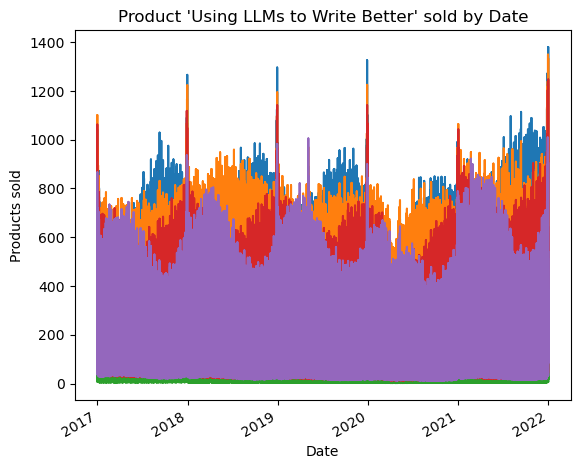

In [15]:
for i in products:
    train_1 = train[train['product']==i]
    #plt.subplot(len(products),1,j)
    #plt.subplot(1,2,len(i))
    plt.plot(train_1['date'],train_1['num_sold'])
    # Giving title to the chart using plt.title
    plt.title(f"Product '{i}' sold by Date")
    # rotating the x-axis tick labels at 30degree
    # towards right
    plt.xticks(rotation=30, ha='right')
 
 # Providing x and y label to the chart
    plt.xlabel('Date')
    plt.ylabel('Products sold')
    
    

In [16]:
train['date'].max()

Timestamp('2021-12-31 00:00:00')

In [17]:
train['date'].min()

Timestamp('2017-01-01 00:00:00')

In [18]:
def new_column(df):
   df['day']=df['date'].dt.day
   df['month']=df['date'].dt.month
   df['year']=df['date'].dt.year
   df=df.drop(['date'],axis=1)
   return df

In [19]:
train= new_column(train)

In [20]:
train.head()

,id,country,store,product,num_sold,day,month,year
0,0,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,1,1,2017
1,1,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,1,1,2017
2,2,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,1,1,2017
3,3,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,1,1,2017
4,4,Argentina,Kaggle Learn,Using LLMs to Write Better,49,1,1,2017


In [21]:
#countries=train['country'].unique()

In [22]:
#stores=train['store'].unique()

In [23]:
X= train.drop(['num_sold'],axis=1)
y= train[['num_sold']]

In [24]:
cbe= CatBoostEncoder(cols = ['country', 'store', 'product']).fit(X,y)
X= cbe.transform(X)


In [25]:
test['date']=pd.to_datetime(test['date'])

In [26]:
test=new_column(test)

In [27]:
test=cbe.transform(test)

In [28]:
def hgbr_objective(trial):
    # Use the trial object to suggest a value for alpha
    # Optuna will come up with a suggested value based on the scores of previous trials
    _alpha = trial.suggest_float("quantile", 0.1, 1)
    _beta = trial.suggest_float("learning_rate", 0.1, 20)
    _gamma = trial.suggest_int("max_iter", 1, 100)
    _delta= trial.suggest_int("max_leaf_nodes", 2, 100)
    _theta= trial.suggest_int("max_depth", 1, 8)
    # Define the model with the suggested alpha
    hgbr = HistGradientBoostingRegressor(quantile=_alpha,learning_rate=_beta,max_iter=_gamma,
                                         max_leaf_nodes= _delta,max_depth=_theta,random_state=42)
    # Calculate the score with 10-folds cross validation, which returns a list of scores
    # scoring is defined as negative RMSE as it is what this Kaggle competition uses to evaluate the result
    scores = cross_val_score(hgbr, X, y, 
                             cv=KFold(n_splits=10,
                                      shuffle=True,
                                      random_state=42),
                             scoring="neg_root_mean_squared_error",error_score='raise'
                            )
    # Return the mean of 10 scores
    return scores.mean()

In [29]:
# Create Study object
study = optuna.create_study(direction="maximize")

[I 2023-07-16 08:39:51,219] A new study created in memory with name: no-name-68ea4ca8-fe08-408b-b3b0-4e7d48df506f


In [30]:
# Optimize the study, use more trials to obtain better result, use less trials to be more cost-efficient
study.optimize(hgbr_objective, n_trials=100) # Use more

[I 2023-07-16 08:39:54,722] Trial 0 finished with value: -29.666081554172923 and parameters: {'quantile': 0.7002837128770173, 'learning_rate': 1.3139429876854798, 'max_iter': 19, 'max_leaf_nodes': 80, 'max_depth': 4}. Best is trial 0 with value: -29.666081554172923.
[I 2023-07-16 08:39:56,286] Trial 1 finished with value: -86798529305424.47 and parameters: {'quantile': 0.969834145170868, 'learning_rate': 15.818799515730714, 'max_iter': 48, 'max_leaf_nodes': 68, 'max_depth': 3}. Best is trial 0 with value: -29.666081554172923.
[I 2023-07-16 08:39:57,964] Trial 2 finished with value: -937862749707.1383 and parameters: {'quantile': 0.28560542632244357, 'learning_rate': 10.386467806092424, 'max_iter': 71, 'max_leaf_nodes': 90, 'max_depth': 4}. Best is trial 0 with value: -29.666081554172923.
[I 2023-07-16 08:40:00,012] Trial 3 finished with value: -225639823008256.44 and parameters: {'quantile': 0.8083103698449841, 'learning_rate': 17.21770885995425, 'max_iter': 79, 'max_leaf_nodes': 33, '

In [31]:
# Print the result
best_params = study.best_params
best_score = study.best_value

In [32]:
best_score

-19.77782523791037

In [33]:
hgbr= HistGradientBoostingRegressor(**best_params,random_state=42)

In [34]:
hgbr.fit(X,y)

HistGradientBoostingRegressor(learning_rate=0.49089459848103356, max_depth=8,
                              max_iter=91, max_leaf_nodes=46,
                              quantile=0.8109912277027663, random_state=42)

In [35]:
#for c in countries:
   # train= train[train['country']==c]
   # for s in stores:
    # train = train[train['store']==s]
   #  new_column= train[['date','num_sold']]
   #  new_column.columns = ['ds', 'y'] 
   #  new_column = new_column.drop_duplicates(subset= 'ds', keep='last')
     
   #  model = n.fit(new_column, freq='D', epochs=10,batch_size=6)

In [36]:
test.head()

,id,country,store,product,day,month,year
0,136950,61.458491,60.373256,221.585430,1,1,2022
1,136951,61.458491,60.373256,218.836133,1,1,2022
2,136952,61.458491,60.373256,34.052409,1,1,2022
3,136953,61.458491,60.373256,185.041748,1,1,2022
4,136954,61.458491,60.373256,168.097460,1,1,2022


In [37]:
prediction = hgbr.predict(test)

In [38]:
output=pd.DataFrame({'id':test.id,'num_sold':prediction})

In [39]:
output.head()

,id,num_sold
0,136950,33.474303
1,136951,33.011834
2,136952,2.607575
3,136953,32.555424
4,136954,27.303691


In [40]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
